In [117]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv, det, eigvals
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import pandas as pd

In [118]:
def compute_metrics_and_print_cm(y_pred, y_true):
    classes = np.unique(np.concatenate((y_true, y_pred))) # Get the unique values of the classes
    n_classes = len(classes)

    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i, actual_class in enumerate(classes):
        for j, predicted_class in enumerate(classes):
            cm[i, j] = np.sum((y_true == actual_class) & (y_pred == predicted_class))

    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    print("Confusion Matrix:")
    print(cm_df)


In [119]:
def evaluate_classifier(y_pred, y_true):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    compute_metrics_and_print_cm(y_pred, y_true)

In [120]:
def plot_mean_vectors(labels, images):
    unique_labels = np.unique(labels)
    mean_vectors = np.zeros((len(unique_labels), 28, 28)) # 28x28 is the size of the images
    for i, label in enumerate(unique_labels):
        class_indices = np.where(labels == label)[0]
        class_images = images[:, :, class_indices] # Get all images of the current class
        mean_vectors[i] = np.mean(class_images, axis=2) # Compute the mean of the images of the current class

    fig, axes = plt.subplots(4, 7, figsize=(14, 8))
    axes = axes.ravel()

    for i, mean_vector in enumerate(mean_vectors):
        axes[i].imshow(mean_vector, cmap='gray')
        axes[i].set_title(f"Mean Vector: {chr(unique_labels[i] + ord('a'))}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [121]:
def train_qda(training_features, training_labels):
    classes = np.unique(training_labels)
    n_classes = len(classes)
    theta = {
        'priors': np.zeros(n_classes),
        'means': np.zeros((n_classes, training_features.shape[1])),
        'covariances': np.zeros((n_classes, training_features.shape[1], training_features.shape[1])), # 2D*2D
        'eigenvalues': np.zeros((n_classes, training_features.shape[1]))
    }

    for i, c in enumerate(classes):
        samples = np.where(training_labels == c)[0] 
        features_c = training_features[samples] # Get features of class c
        theta['means'][i] = np.mean(features_c, axis=0)
        cov_matrix = np.cov(features_c, rowvar=False)
        theta['covariances'][i] = cov_matrix
        theta['eigenvalues'][i] = eigvals(cov_matrix)
        theta['priors'][i] = features_c.shape[0] / float(training_features.shape[0]) 

    return theta

In [122]:
def predict_qda(X, theta):
    means = theta['means']
    covariances = theta['covariances']
    priors = theta['priors']
    n_classes = len(means)

    log_likelihoods = np.zeros((X.shape[0], n_classes)) # n_samples x n_classes

    for i in range(n_classes):
        eigvals = np.linalg.eigvals(covariances[i])
        if np.any(eigvals <= 0):
            covariances[i] += np.eye(covariances[i].shape[0]) * 1e-3 # Plus an epsilon to ensure its positive

        log_likelihoods[:, i] = multivariate_normal.logpdf(X, mean=means[i].flatten(), cov=covariances[i]) + np.log(priors[i])

    return np.argmax(log_likelihoods, axis=1) # Return the index of the class with the highest likelihood

In [123]:
#Q6.a

with open('TrainData.pkl', 'rb') as file:
    train_data = pickle.load(file)

train_images = train_data['X']
train_labels = train_data['Y']

reshaped_train_images = np.transpose(train_images, (2, 0, 1))
flattened_train_images = (reshaped_train_images.reshape(reshaped_train_images.shape[0], -1)).astype(np.float64)

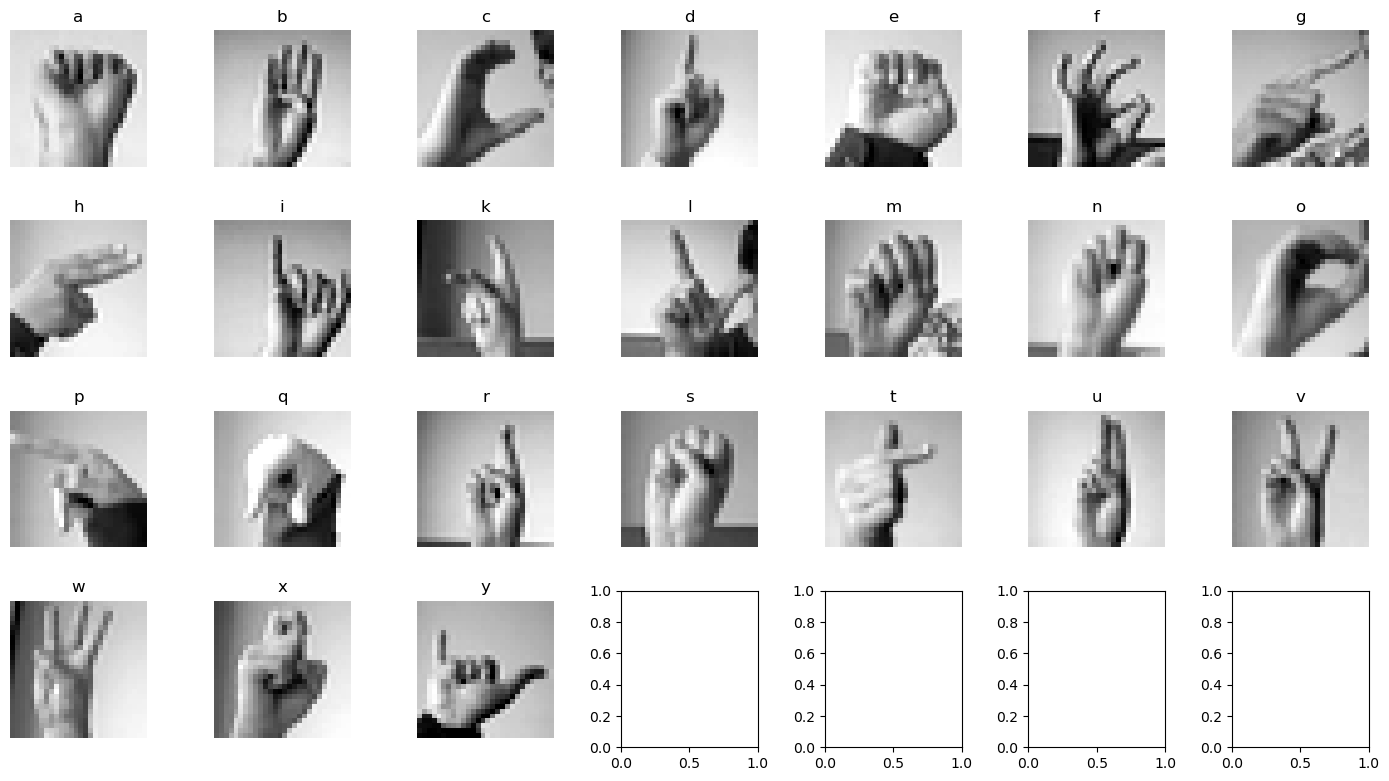

In [124]:
#Q6.b

unique_labels = np.unique(train_labels)
label_map = {label: i for i, label in enumerate(unique_labels)}
mapped_labels = np.array([label_map[label] for label in train_labels])

num_rows = 4
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
axes = axes.ravel()

for i, label in enumerate(unique_labels):
    idx = np.where(train_labels == label)[0][0]
    axes[i].imshow(train_images[:, :, idx], cmap='gray')
    axes[i].set_title(f"{chr(label + ord('a'))}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [125]:
#Q8.a

theta = train_qda(flattened_train_images, train_labels)

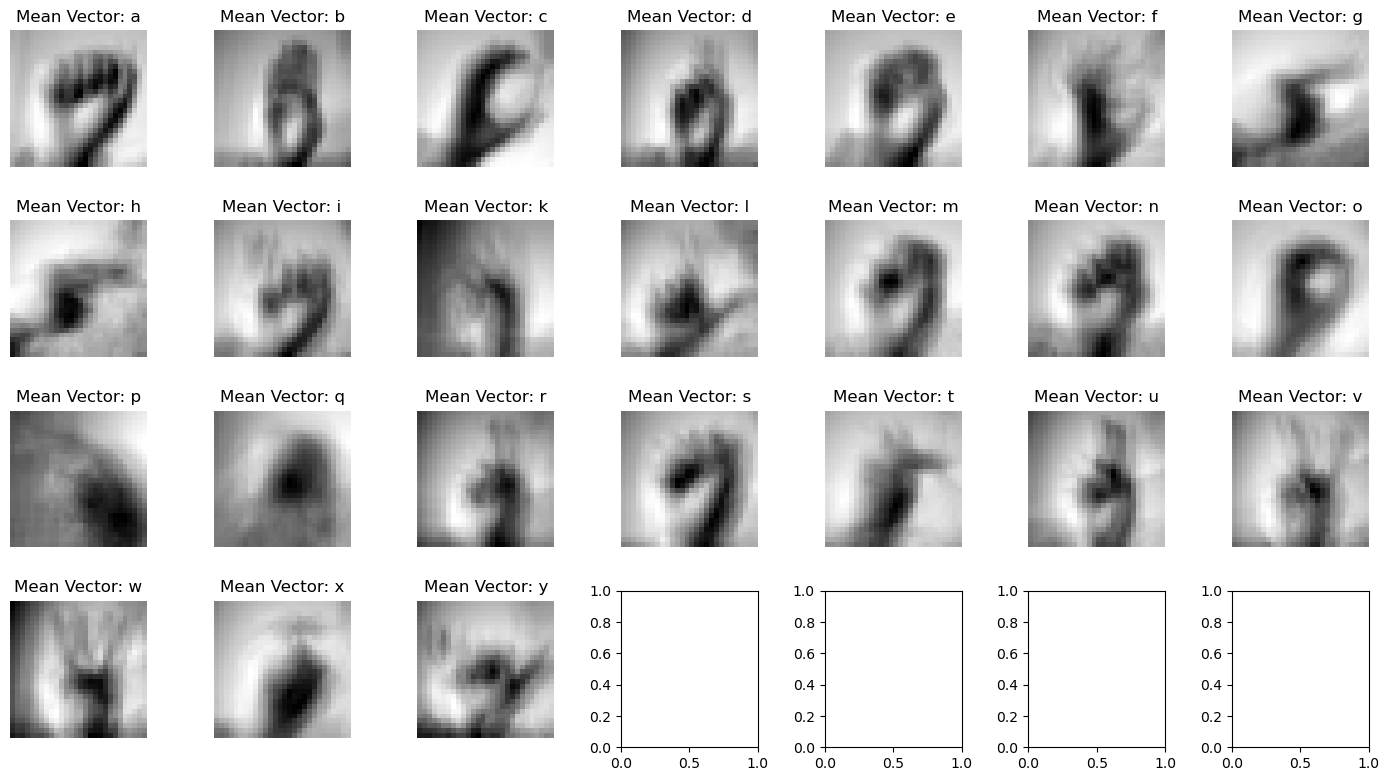

In [126]:
plot_mean_vectors(train_labels, train_images)

In [127]:
predictions = predict_qda(flattened_train_images, theta)
mapped_predictions = np.array([unique_labels[label] for label in predictions])
evaluate_classifier(mapped_predictions, train_labels)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1126
           1       1.00      1.00      1.00      1010
           2       1.00      1.00      1.00      1144
           3       1.00      1.00      1.00      1196
           4       1.00      1.00      1.00       957
           5       1.00      1.00      1.00      1204
           6       1.00      1.00      1.00      1090
           7       1.00      1.00      1.00      1013
           8       1.00      1.00      1.00      1162
          10       1.00      1.00      1.00      1114
          11       1.00      1.00      1.00      1241
          12       1.00      1.00      1.00      1055
          13       1.00      1.00      1.00      1151
          14       1.00      1.00      1.00      1196
          15       1.00      1.00      1.00      1088
          16       1.00      1.00      1.00      1279
          17       1.00      1.00      1.00      1294
    

In [128]:
with open('TestData.pkl', 'rb') as file:
    test_data = pickle.load(file)

test_images = test_data['X']
test_labels = test_data['Y']

reshaped_test_images = np.transpose(test_images, (2, 0, 1)) # (num_images, 28, 28)
flattened_test_images = (reshaped_test_images.reshape(reshaped_test_images.shape[0], -1)).astype(np.float64)

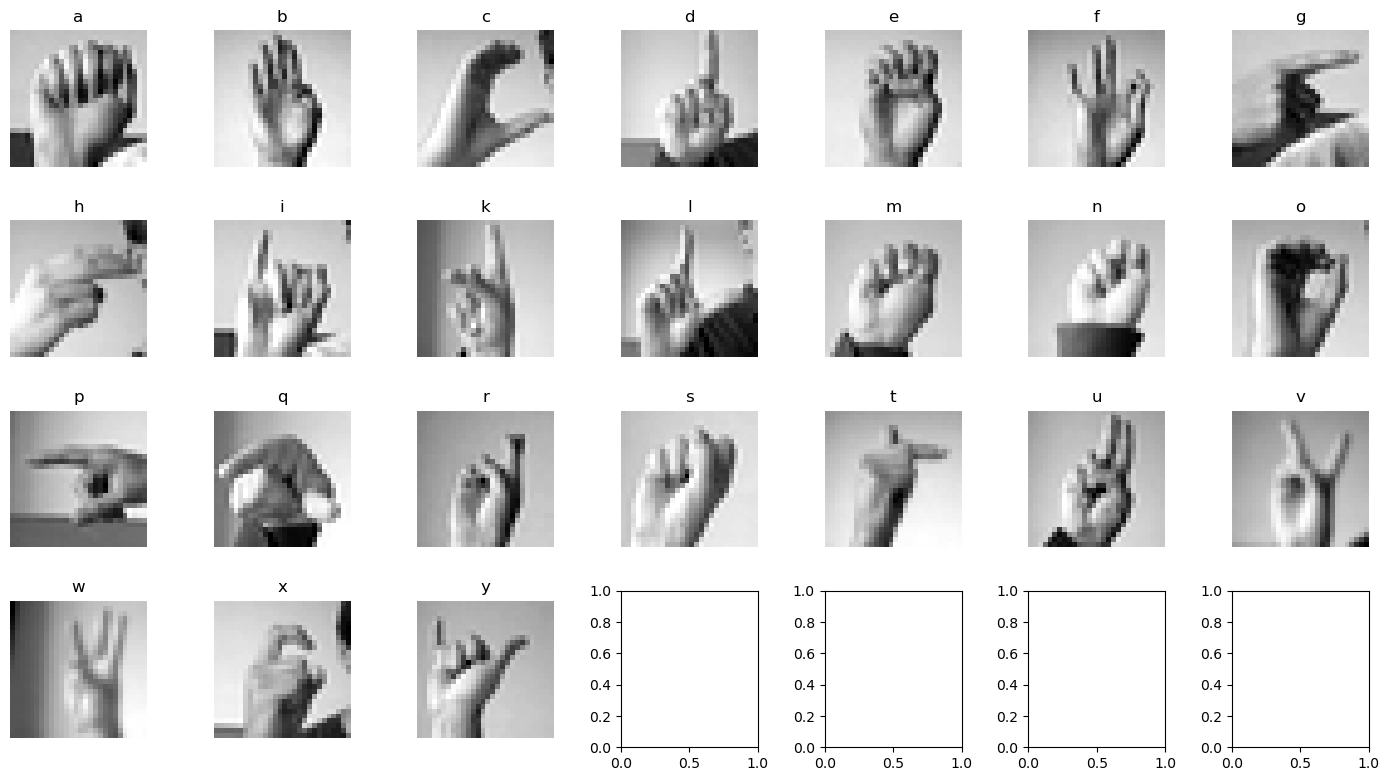

In [129]:
unique_labels = np.unique(test_labels)
label_map = {label: i for i, label in enumerate(unique_labels)}
mapped_labels = np.array([label_map[label] for label in test_labels])

num_rows = 4
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
axes = axes.ravel()

for i, label in enumerate(unique_labels):
    idx = np.where(test_labels == label)[0][0]
    axes[i].imshow(test_images[:, :, idx], cmap='gray')
    axes[i].set_title(f"{chr(label + ord('a'))}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [130]:
theta_test = train_qda(flattened_test_images, test_labels)

C:\Users\Shahar\AppData\Local\Temp\ipykernel_35760\2690363393.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  theta['eigenvalues'][i] = eigvals(cov_matrix)


In [131]:
test_predictions = predict_qda(flattened_test_images, theta_test)
mapped_predictions_test = np.array([unique_labels[label] for label in test_predictions])
evaluate_classifier(mapped_predictions_test, test_labels)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       291
           2       1.00      1.00      1.00       293
           3       1.00      1.00      1.00       231
           4       1.00      1.00      1.00       234
           5       1.00      1.00      1.00       245
           6       1.00      1.00      1.00       264
           7       1.00      1.00      1.00       208
           8       1.00      1.00      1.00       235
          10       1.00      1.00      1.00       245
          11       1.00      1.00      1.00       193
          12       1.00      1.00      1.00       198
          13       1.00      1.00      1.00       227
          14       1.00      1.00      1.00       175
          15       1.00      1.00      1.00       115
          16       1.00      1.00      1.00       164
          17       1.00      1.00      1.00       140
    

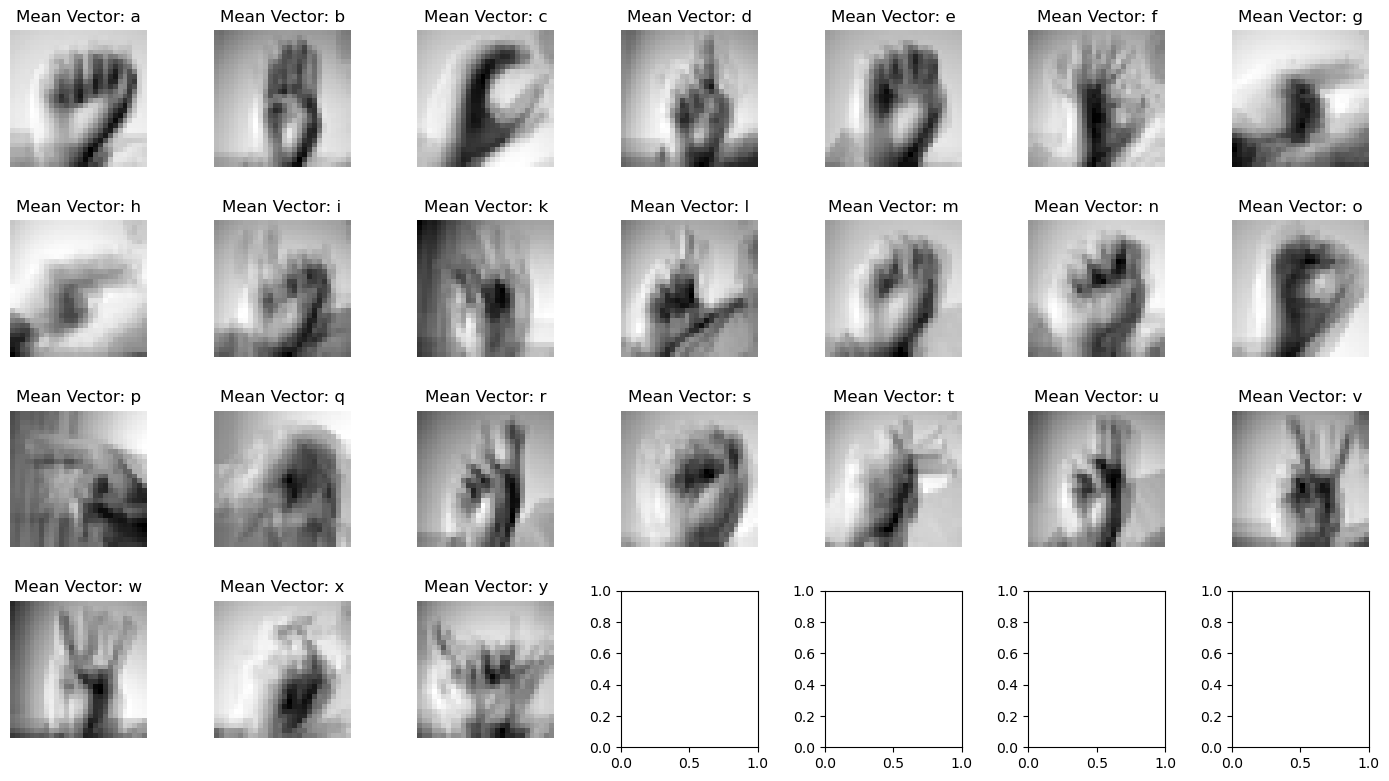

In [132]:
plot_mean_vectors(test_labels, test_images)

In [133]:
test_predictions = predict_qda(flattened_test_images, theta)
mapped_predictions_test = np.array([unique_labels[label] for label in test_predictions])
evaluate_classifier(mapped_predictions_test, test_labels)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.93      0.96       291
           2       1.00      0.99      0.99       293
           3       0.98      0.98      0.98       231
           4       1.00      0.82      0.90       234
           5       1.00      1.00      1.00       245
           6       0.97      0.93      0.95       264
           7       1.00      0.81      0.89       208
           8       1.00      0.97      0.98       235
          10       0.99      0.93      0.96       245
          11       1.00      0.97      0.99       193
          12       1.00      0.80      0.89       198
          13       0.88      0.94      0.91       227
          14       0.98      0.96      0.97       175
          15       1.00      0.56      0.72       115
          16       0.46      1.00      0.63       164
          17       0.75      1.00      0.86       140
    

In [134]:
with open('MessageData.pkl', 'rb') as file:
    message_data = pickle.load(file)

message_images = message_data['X']

# print(message_images.shape)

reshaped_msg_images = np.transpose(message_images, (2, 0, 1)) # (num_images, 28, 28)
flattened_msg_images = (reshaped_msg_images.reshape(reshaped_msg_images.shape[0], -1)).astype(np.float64)

vec_index = [] 
for i, img in enumerate(flattened_msg_images):
    if np.sum(img) == 0:
        vec_index.append(i)

In [135]:
msg=predict_qda(flattened_msg_images, theta)

In [136]:
msg[vec_index] = 25

for i in range(len(msg)):
    if msg[i]>=9:
        msg[i]+=1
    if msg[i]==26:
        print(" ", end="")
    else:
        print(chr(ord('a')+msg[i]), end="")
print('\n')


a great way to learn how a machine learning algorithm works is by implementing it from scratch

